In [1]:
!pip install mediapipe opencv-python-headless numpy scikit-learn pandas


In [2]:
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np, cv2

def capture_image():
    js_code = '''
    async function captureImage() {
      const div = document.createElement('div');
      const btn = document.createElement('button');
      btn.textContent = '📸 Capture Image';
      div.appendChild(btn);
      document.body.appendChild(div);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      await new Promise(resolve => btn.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      video.remove(); btn.remove(); div.remove();

      return canvas.toDataURL('image/jpeg', 0.8);
    }
    captureImage();
    '''
    data_url = eval_js(js_code)
    header, encoded = data_url.split(',', 1)
    img_bytes = b64decode(encoded)
    return cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)


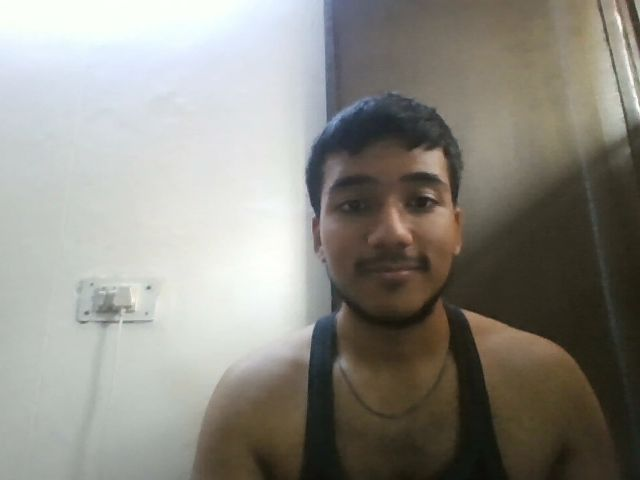

In [3]:
from google.colab.patches import cv2_imshow

# Make sure this shows your webcam frame!
img = capture_image()
cv2_imshow(img)


In [41]:
import mediapipe as mp
import math

# Updated landmark indices
LEFT_EYE_UP    = [159, 145]
LEFT_EYE_LOW   = [33, 133]
RIGHT_EYE_UP   = [386, 374]
RIGHT_EYE_LOW  = [362, 263]
MOUTH_UP       = [13, 14, 0]
MOUTH_LOW      = [17, 84, 87]
MOUTH_CORNER   = [61, 291]  # more stable than 78/308
LS, RS, LH, RH = 11, 12, 23, 24  # shoulders & hips

# Utility functions
def dist3D(a, b):
    return math.sqrt((a.x - b.x) ** 2 + (a.y - b.y) ** 2 + (a.z - b.z) ** 2)

def vector_angle(v1, v2):
    dot = sum(a*b for a, b in zip(v1, v2))
    mag1 = math.sqrt(sum(a*a for a in v1))
    mag2 = math.sqrt(sum(b*b for b in v2))
    if mag1 * mag2 == 0:
        return 0
    return math.degrees(math.acos(dot / (mag1 * mag2)))

def compute_features(flm, plm, img_shape):
    if not flm or not plm:
        return None

    h, w = img_shape[:2]
    landmarks_face = flm.landmark
    landmarks_pose = plm.landmark

    def ear3D(up_idxs, low_idxs):
        verts = [dist3D(landmarks_face[u], landmarks_face[l]) for u, l in zip(up_idxs, low_idxs)]
        horiz = dist3D(landmarks_face[up_idxs[0]], landmarks_face[low_idxs[0]])
        return sum(verts) / len(verts) / horiz if horiz > 0 else 0

    def mar3D():
        up = [landmarks_face[i] for i in MOUTH_UP]
        low = [landmarks_face[i] for i in MOUTH_LOW]
        corners = [landmarks_face[i] for i in MOUTH_CORNER]
        vertical = sum(dist3D(u, l) for u, l in zip(up, low)) / len(up)
        horiz = dist3D(corners[0], corners[1])
        return vertical / horiz if horiz > 0 else 0

    def slouch_angle():
        ls, rs = landmarks_pose[LS], landmarks_pose[RS]
        lh, rh = landmarks_pose[LH], landmarks_pose[RH]
        mid_s = [(ls.x + rs.x) / 2, (ls.y + rs.y) / 2]
        mid_h = [(lh.x + rh.x) / 2, (lh.y + rh.y) / 2]
        vec = [mid_h[0] - mid_s[0], mid_h[1] - mid_s[1]]
        return vector_angle(vec, [0, 1])  # angle vs vertical

    return {
        'ear_left':  ear3D(LEFT_EYE_UP, LEFT_EYE_LOW),
        'ear_right': ear3D(RIGHT_EYE_UP, RIGHT_EYE_LOW),
        'mar':       mar3D(),
        'slouch_ang': slouch_angle()
    }


In [42]:
import pandas as pd, cv2

records, labels = [], []

for label, desc in [(0,'Active'), (1,'Tired')]:
    print(f"Collecting {desc} frames")
    for i in range(20):            # ← was 3, now 20 samples each
        print(" Capture", i+1)
        img = capture_image()      # click the 📸 button each time
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fr = face_mesh.process(img_rgb)
        pr = pose.process(img_rgb)
        if fr.multi_face_landmarks and pr.pose_landmarks:
            f = compute_features(fr.multi_face_landmarks[0], pr.pose_landmarks, img.shape)
            records.append(f); labels.append(label)
        else:
            print("  skipped")

df = pd.DataFrame(records)
df['label'] = labels
df.head()


 Capture 1
 Capture 2
 Capture 3
 Capture 4
 Capture 5
 Capture 6
 Capture 7
 Capture 8
 Capture 9
 Capture 10
 Capture 11
 Capture 12
 Capture 13
 Capture 14
 Capture 15
 Capture 16
 Capture 17
 Capture 18
 Capture 19
 Capture 20
 Capture 1
 Capture 2
 Capture 3
 Capture 4
 Capture 5
 Capture 6
 Capture 7
 Capture 8
 Capture 9
 Capture 10
 Capture 11
 Capture 12
 Capture 13
 Capture 14
 Capture 15
 Capture 16
 Capture 17
 Capture 18
 Capture 19
 Capture 20


,ear_left,ear_right,mar,slouch_ang,label
0,0.975808,0.971215,0.189548,1.632787,0
1,0.998022,0.965236,0.270456,2.841402,0
2,0.982571,0.986830,0.184138,2.097565,0
3,0.991823,0.985203,0.239937,2.226842,0
4,0.995622,0.994131,0.224726,0.989217,0


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df[['ear_left','ear_right','mar','slouch_ang']]
y = df['label']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y            # ← ensures both classes in test set
)

clf = LogisticRegression().fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=['Active','Tired']))


              precision    recall  f1-score   support

      Active       0.50      0.17      0.25         6
       Tired       0.50      0.83      0.62         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.44        12
weighted avg       0.50      0.50      0.44        12



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


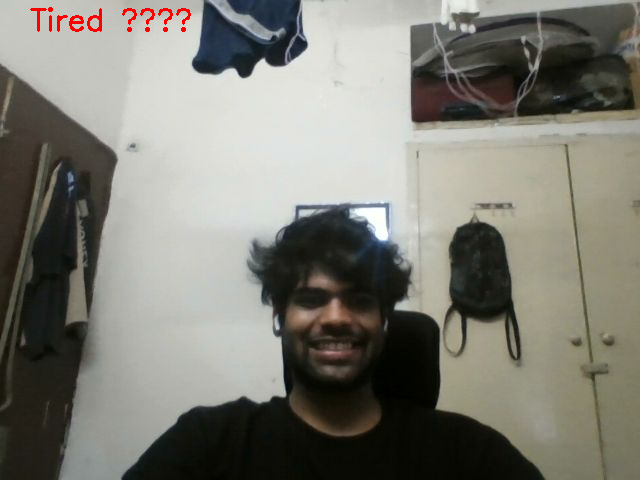

In [46]:
from google.colab.patches import cv2_imshow
import cv2

votes = []
for _ in range(5):                   # capture 5 frames
    img = capture_image()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fr = face_mesh.process(img_rgb)
    pr = pose.process(img_rgb)
    f = compute_features(fr.multi_face_landmarks[0], pr.pose_landmarks, img.shape)
    votes.append(clf.predict([[f['ear_left'], f['ear_right'], f['mar'], f['slouch_ang']]])[0])

# majority vote
label = 1 if sum(votes) > 2 else 0
msg = "Tired 😴" if label else "Active 🙂"

# show last frame with label
cv2.putText(img, msg, (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
cv2_imshow(img)


In [47]:
import joblib

# Save the trained model to a file in Colab’s filesystem
joblib.dump(clf, 'mindmood_model.joblib')
print("Model saved to mindmood_model.joblib")


Model saved to mindmood_model.joblib


Features:
  ear_left: 0.947
  ear_right: 1.023
  mar: 0.351
  slouch_ang: 1.270

Predicted probabilities:
  Active  (class 0): 0.523
  Tired   (class 1): 0.477

Model verdict: Active 🙂


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


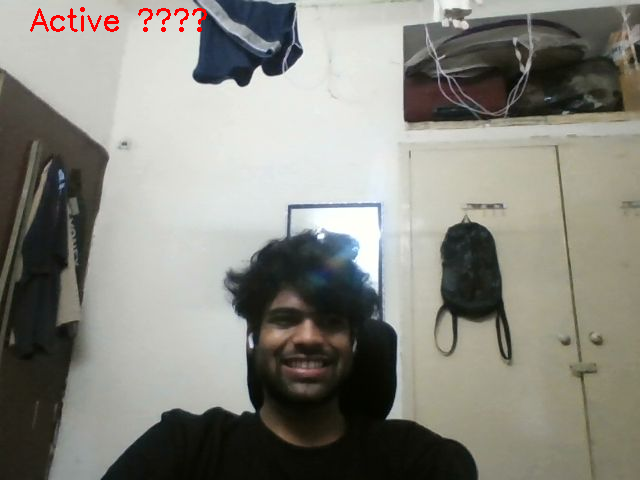

In [49]:
import joblib
from google.colab.patches import cv2_imshow
import cv2

# Load the saved model
clf2 = joblib.load('mindmood_model.joblib')

# 1) Capture one frame
img = capture_image()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fr = face_mesh.process(img_rgb)
pr = pose.process(img_rgb)
f = compute_features(fr.multi_face_landmarks[0], pr.pose_landmarks, img.shape)

# 2) Show the feature values
print("Features:")
for k,v in f.items():
    print(f"  {k}: {v:.3f}")

# 3) Get and print class probabilities
proba = clf2.predict_proba([[f['ear_left'], f['ear_right'], f['mar'], f['slouch_ang']]])[0]
print("\nPredicted probabilities:")
print(f"  Active  (class 0): {proba[0]:.3f}")
print(f"  Tired   (class 1): {proba[1]:.3f}")

# 4) Final label decision
label = clf2.predict([[f['ear_left'], f['ear_right'], f['mar'], f['slouch_ang']]])[0]
msg = "Tired 😴" if label else "Active 🙂"
print("\nModel verdict:", msg)

# 5) Overlay and show
cv2.putText(img, msg, (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
cv2_imshow(img)
